✅ Loaded previous model and optimizer state.


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Epoch 1/25, Loss: 2.8751, Accuracy: 75.27%, ε: 0.70
Epoch 2/25, Loss: 2.5141, Accuracy: 74.61%, ε: 0.96
Epoch 3/25, Loss: 2.7892, Accuracy: 74.30%, ε: 1.17
Epoch 4/25, Loss: 3.4219, Accuracy: 75.00%, ε: 1.34
Epoch 5/25, Loss: 2.5348, Accuracy: 73.15%, ε: 1.50
Epoch 6/25, Loss: 4.3803, Accuracy: 77.66%, ε: 1.65
Epoch 7/25, Loss: 2.7922, Accuracy: 76.50%, ε: 1.78
Epoch 8/25, Loss: 2.5408, Accuracy: 81.19%, ε: 1.91
Epoch 9/25, Loss: 2.5465, Accuracy: 76.76%, ε: 2.03
Epoch 10/25, Loss: 3.5065, Accuracy: 76.72%, ε: 2.14
Epoch 11/25, Loss: 2.9667, Accuracy: 74.43%, ε: 2.25
Epoch 12/25, Loss: 3.4659, Accuracy: 80.61%, ε: 2.36
Epoch 13/25, Loss: 3.8405, Accuracy: 83.42%, ε: 2.46
Epoch 14/25, Loss: 2.3182, Accuracy: 77.62%, ε: 2.56
Epoch 15/25, Loss: 3.6269, Accuracy: 79.23%, ε: 2.65
Epoch 16/25, Loss: 2.4965, Accuracy: 73.30%, ε: 2.74
Epoch 17/25, Loss: 3.4298, Accuracy: 73.27%, ε: 2.83
Epoch 18/25, Loss: 2.5339, Accuracy: 73.91%, ε: 2.92
Epoch 19/25, Loss: 3.0086, Accuracy: 69.00%, ε: 3.01
Ep

/tmp/ipython-input-19-2324249891.py:174: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128272 (\N{CLOSED LOCK WITH KEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


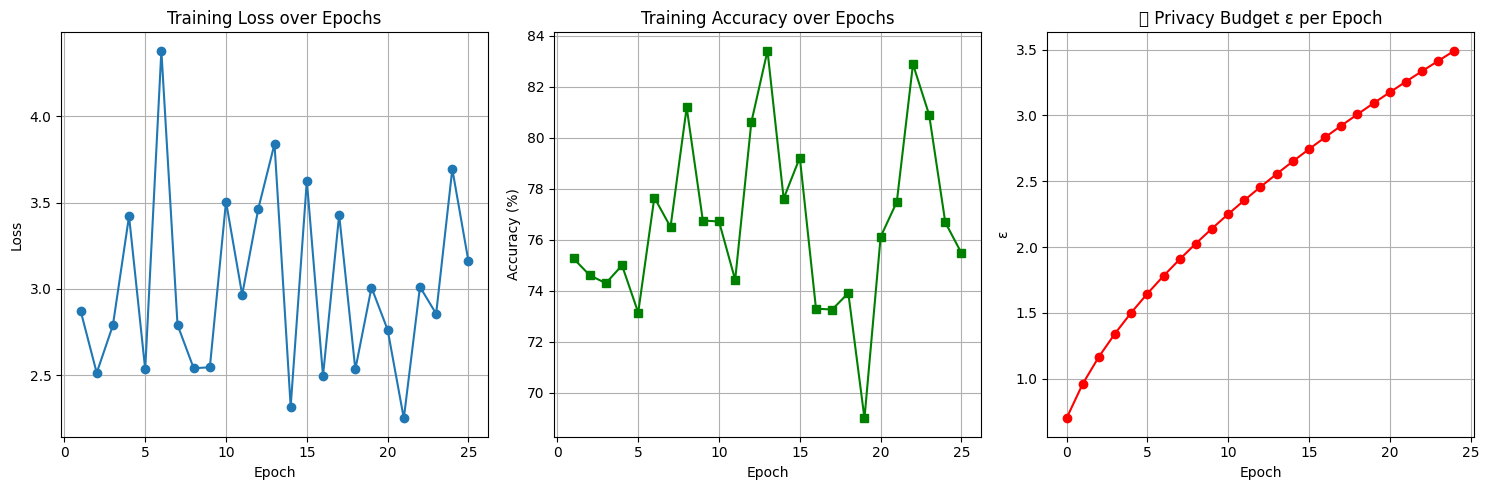

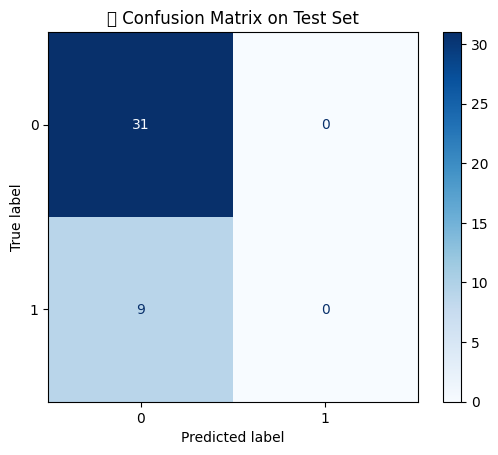

In [19]:
# ✅ FULL CODE TO: Upload CSV, Train Model with DP, Save, Load, Continue Training
# STEP 1: Install Required Libraries
!pip install opacus pandas scikit-learn matplotlib --quiet

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from opacus import PrivacyEngine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
import os # Import os for checking file existence

# ======= USER CHOICE: NEW or CONTINUE TRAINING =======
mode = "continue"  # change to "continue" to load existing model and train further
csv_path = "/content/sample_medical_data.csv"  # update this to your own uploaded file
checkpoint_path = "dp_model_checkpoint.pth"

# ======= STEP 1: LOAD CSV FILE =======
df = pd.read_csv(csv_path)

# Encode categorical variables (e.g., 'Sex', 'Smoker')
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = LabelEncoder().fit_transform(df[col])


# Assume last column is target
y = df.iloc[:, -1].values
X = df.iloc[:, :-1].values.astype(np.float32)

"""
from sklearn.preprocessing import StandardScaler
df['label'] = (df['charges'] > 15000).astype(int)  # Binary label
X = df.drop(columns=['charges', 'label'])
y = df['label'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)
"""

X_tensor = torch.tensor(X)
y_tensor = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)
"""X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
"""
input_dim = X.shape[1]

# ======= STEP 2: DEFINE MODEL =======
class SimpleFCNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2) # Changed output dimension to 2

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleFCNN(input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# ======= STEP 3: LOAD IF CONTINUING TRAINING =======
if mode == "continue" and os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    # Remove the "_module." prefix from the state_dict keys
    state_dict = {k.replace('_module.', ''): v for k, v in checkpoint['model_state_dict'].items()}
    model.load_state_dict(state_dict)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("✅ Loaded previous model and optimizer state.")
elif mode == "continue" and not os.path.exists(checkpoint_path):
    print(f"⚠️ Checkpoint file '{checkpoint_path}' not found. Starting new training.")


# ======= STEP 4: ATTACH PRIVACY ENGINE =======
privacy_engine = PrivacyEngine()
model, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    target_epsilon=3.5,
    target_delta=1e-5,
    epochs=25,
    max_grad_norm=1.0,
)

# ======= STEP 5: TRAIN MODEL =======
epochs = 25
loss_fn = nn.CrossEntropyLoss()
train_losses = []
train_accuracies = []
epsilon_values = []


for epoch in range(epochs):
    model.train() # Set model to training mode
    epoch_loss = 0
    correct = 0
    total = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device) # Move data to device
        optimizer.zero_grad()
        preds = model(batch_x)
        loss = loss_fn(preds, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        _, predicted = torch.max(preds.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    accuracy = 100 * correct / total
    train_accuracies.append(accuracy)


    epsilon = privacy_engine.get_epsilon(delta=1e-5)
    epsilon_values.append(epsilon)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, ε: {epsilon:.2f}")

# ======= STEP 6: SAVE MODEL STATE =======
torch.save({
    'model_state_dict': model._module.state_dict(), # Save the original module's state dict
    'optimizer_state_dict': optimizer.state_dict(),
}, checkpoint_path)
print(f"✅ Saved model checkpoint to {checkpoint_path}")

# ======= STEP 7: PLOT LOSS AND ACCURACY CURVES =======
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accuracies, marker='s', color='green')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epsilon_values, marker='o', color='red')
plt.title("🔐 Privacy Budget ε per Epoch")
plt.xlabel("Epoch")
plt.ylabel("ε")
plt.grid(True)

plt.tight_layout()
plt.show()

# ======= STEP 8: CONFUSION MATRIX ON TEST SET =======
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        preds = model(batch_x)
        predicted = torch.argmax(preds, dim=1).cpu().numpy()
        y_pred.extend(predicted)
        y_true.extend(batch_y.numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title("🧠 Confusion Matrix on Test Set")
plt.grid(False)
plt.show()
